**FULL STATISTICAL PROCESS CONTROL ANALYSIS**

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Adjust the file path location when necessary

In [ ]:
file_path = r"C:\Users\U1078446\Downloads\Processed_TestingMFGData.csv"

In [ ]:
# Load the CSV file
df = pd.read_csv(file_path)
df.info()
df.head()

In [46]:
# Parse the 'Time' column
df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
df.set_index('Time', inplace=True)
df.sort_index(inplace=True)

In [47]:
# Parameters to plot
parameters = df.columns.tolist()

**Indicate here; the Upper Control Limit (UCL) and Lower Control Limit (LCL) based on the parameter**

In [48]:
# Define user-specified UCL and LCL values for each parameter
ucl_lcl_values = {}

# Assign control limits based on column position (0-based indexing)
if len(parameters) > 0:  # Column 0 (index 0) - Temperature
    ucl_lcl_values[parameters[0]] = {'UCL': 37.5, 'LCL': 36.5}

if len(parameters) > 1:  # Column 1 (index 1) - DO
    ucl_lcl_values[parameters[1]] = {'UCL': 63.0, 'LCL': 57.0}

if len(parameters) > 2:  # Column 2 (index 2) - PH
    ucl_lcl_values[parameters[2]] = {'UCL': 6.9, 'LCL': 6.83}

# Filter parameters to only include those with defined control limits
parameters = list(ucl_lcl_values.keys())

Overall Statistical Summary

In [49]:
# Print statistical summaries
summary = df[parameters].describe().loc[['mean', '50%', 'min', 'max', 'std']]
summary.rename(index={'50%': 'median'}, inplace=True)
summary = summary.map(lambda x: float(f"{x:.4f}"))

print("Statistical Summary:\n")
print(summary)

Statistical Summary:

        Parameter1  Parameter2  Parameter3
mean       36.9986     60.0394      6.8777
median     37.0000     59.9900      6.8800
min        31.6000     53.2300      6.7800
max        40.4000     66.9600      6.9300
std         0.2086      1.1039      0.0114


Control Limit Violation Summary 

In [50]:
def identify_control_limit_violations(df, param, ucl, lcl):
    data = df[param].dropna()  # Remove any NaN values
    
    # Find violations
    above_ucl = data[data > ucl]
    below_lcl = data[data < lcl]
    
    violations = {
        'above_ucl': above_ucl,
        'below_lcl': below_lcl,
        'total_violations': len(above_ucl) + len(below_lcl),
        'violation_rate': (len(above_ucl) + len(below_lcl)) / len(data) * 100
    }
    
    return violations

def print_violation_summary(df, parameters, ucl_lcl_values):
    print("CONTROL LIMIT VIOLATIONS SUMMARY:")

    
    for param in parameters:
        ucl = ucl_lcl_values[param]['UCL']
        lcl = ucl_lcl_values[param]['LCL']
        violations = identify_control_limit_violations(df, param, ucl, lcl)
        
        print(f"\n{param}:")
        print(f"  Total violations: {violations['total_violations']}")
        print(f"  Violation rate: {violations['violation_rate']:.2f}%")
        print(f"  Above UCL ({ucl}): {len(violations['above_ucl'])} points")
        print(f"  Below LCL ({lcl}): {len(violations['below_lcl'])} points")
        
        # Print ALL timestamps of violations
        if len(violations['above_ucl']) > 0:
            print(f"\n  ALL Time-Stamps above UCL:")
            for timestamp, value in violations['above_ucl'].items():
                print(f"    {timestamp}; {value:.4f}")
        
        if len(violations['below_lcl']) > 0:
            print(f"\n  ALL Time-Stamps below LCL:")
            for timestamp, value in violations['below_lcl'].items():
                print(f"    {timestamp}; {value:.4f}")

def plot_spc_with_violations(df, param, ucl, lcl):
    plt.figure(figsize=(18, 6))
    
    # Plot the main line
    plt.plot(df.index, df[param], label=param, color='blue', linewidth=1.5, alpha=0.8)
    
    # Plot control limits
    plt.axhline(y=ucl, color='red', linestyle='--', linewidth=2, label=f'Upper Ctrl Limit ({ucl})')
    plt.axhline(y=lcl, color='red', linestyle='--', linewidth=2, label=f'Lower Ctrl Limit ({lcl})')
    plt.axhline(y=df[param].mean(), color='green', linestyle='-', linewidth=2, label=f'Center Line ({df[param].mean():.3f})')
    
    # Get violations
    violations = identify_control_limit_violations(df, param, ucl, lcl)
    
    # Scatter plot for points above UCL
    if len(violations['above_ucl']) > 0:
        plt.scatter(violations['above_ucl'].index, violations['above_ucl'].values, 
                   color='red', s=80, marker='o', zorder=5, 
                   label=f'Above UCL ({len(violations["above_ucl"])} points)', 
                   edgecolors='darkred', linewidth=2)
    
    # Scatter plot for points below LCL
    if len(violations['below_lcl']) > 0:
        plt.scatter(violations['below_lcl'].index, violations['below_lcl'].values, 
                   color='orange', s=80, marker='s', zorder=5, 
                   label=f'Below LCL ({len(violations["below_lcl"])} points)', 
                   edgecolors='darkorange', linewidth=2)
    
    # Add warning zones (optional - typically ±2 sigma from center line)
    mean_val = df[param].mean()
    std_val = df[param].std()
    upper_warning = min(mean_val + 2*std_val, ucl)
    lower_warning = max(mean_val - 2*std_val, lcl)
    
    plt.axhline(y=upper_warning, color='yellow', linestyle=':', alpha=0.7, label=f'Upper Warning ({upper_warning:.3f})')
    plt.axhline(y=lower_warning, color='yellow', linestyle=':', alpha=0.7, label=f'Lower Warning ({lower_warning:.3f})')
    
    # Formatting
    plt.title(f'{param} Stats Process Ctrl Chart with Ctrl Limit Violations\n'
              f'Total Violations: {violations["total_violations"]} ({violations["violation_rate"]:.2f}%)', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel(param, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    return violations

# Print violation summary
print_violation_summary(df, parameters, ucl_lcl_values)

CONTROL LIMIT VIOLATIONS SUMMARY:

Parameter1:
  Total violations: 6
  Violation rate: 0.52%
  Above UCL (37.5): 2 points
  Below LCL (36.5): 4 points

  ALL Time-Stamps above UCL:
    2025-06-23 12:15:00; 40.4000
    2025-06-23 12:30:00; 37.7500

  ALL Time-Stamps below LCL:
    2025-06-23 11:15:00; 36.3900
    2025-06-23 11:30:00; 31.6000
    2025-06-23 11:45:00; 35.4000
    2025-06-23 12:00:00; 35.3800

Parameter2:
  Total violations: 37
  Violation rate: 3.21%
  Above UCL (63.0): 28 points
  Below LCL (57.0): 9 points

  ALL Time-Stamps above UCL:
    2025-06-18 00:30:00; 63.3100
    2025-06-18 01:15:00; 63.9400
    2025-06-18 02:15:00; 63.9600
    2025-06-18 03:15:00; 64.0900
    2025-06-18 04:15:00; 63.4600
    2025-06-18 04:30:00; 63.1000
    2025-06-18 05:15:00; 64.0300
    2025-06-18 06:30:00; 63.9200
    2025-06-18 06:45:00; 63.4200
    2025-06-18 08:15:00; 63.8400
    2025-06-18 09:45:00; 63.6300
    2025-06-18 10:00:00; 63.1000
    2025-06-18 11:15:00; 63.3500
    2025-06-1

Plotting

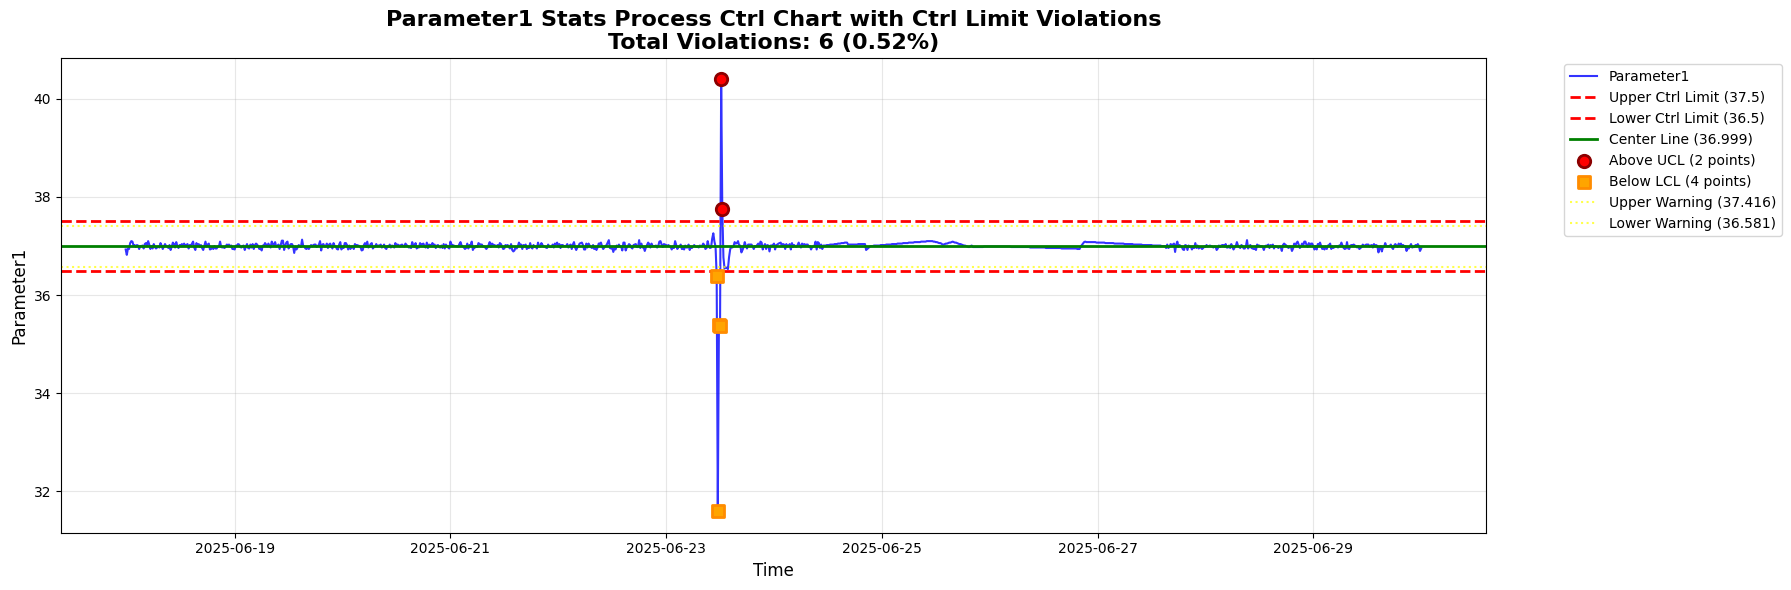

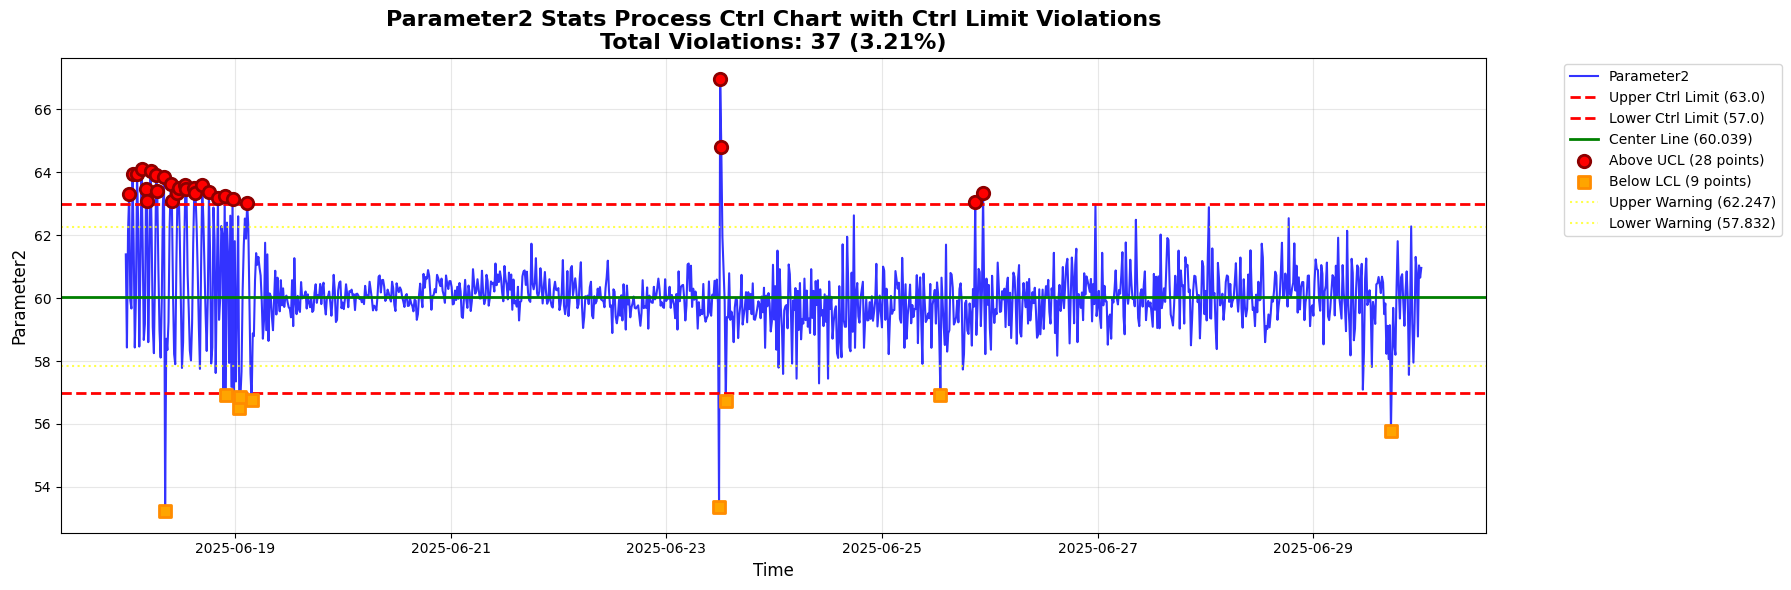

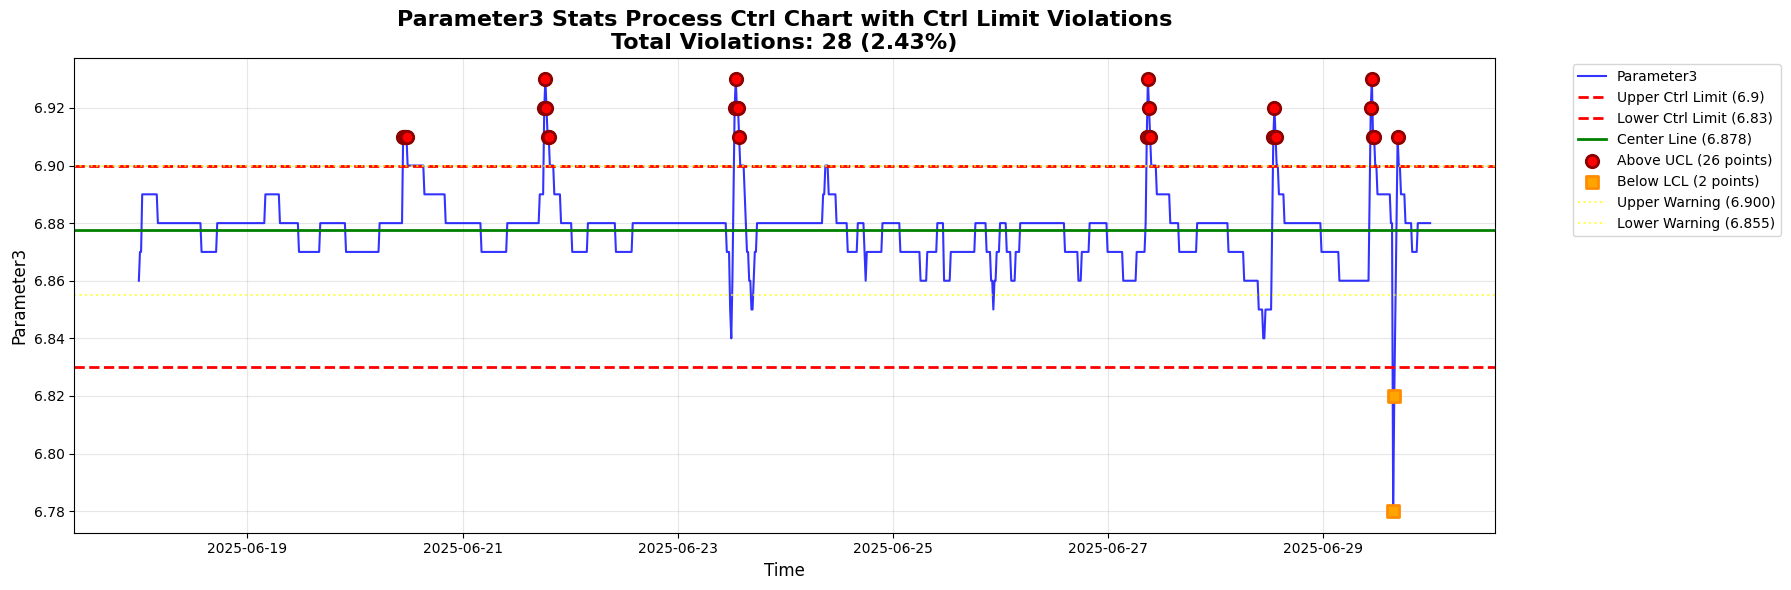

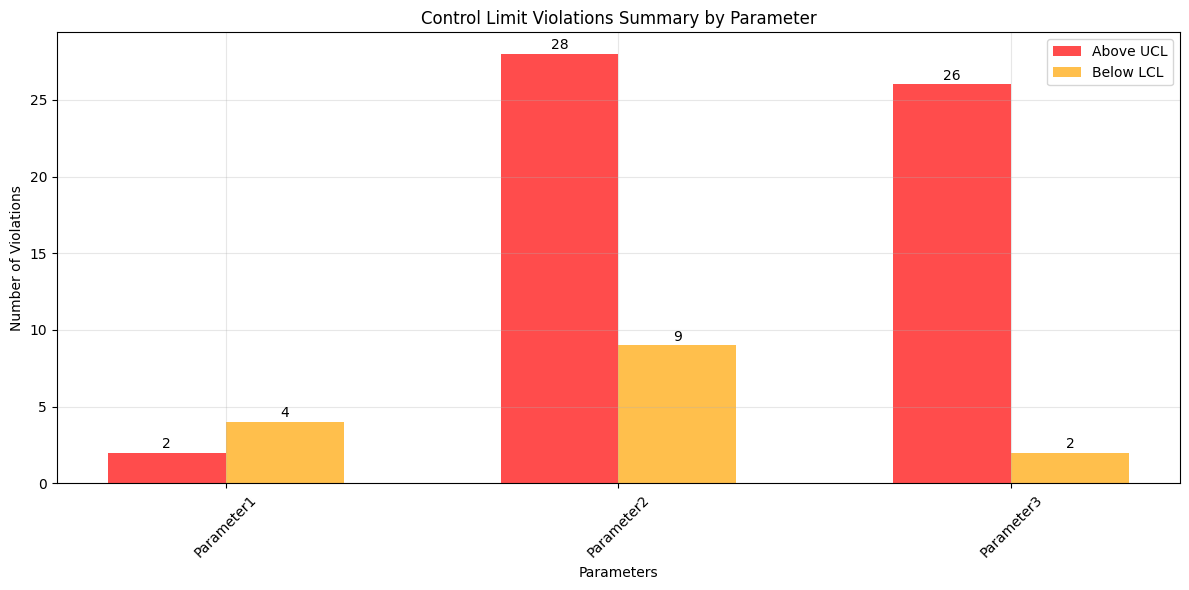

SPC ANALYSIS

Key Features:

 - Scatter points highlighting control limit violations
 - Different markers for UCL (circles) vs LCL (squares) violations
 - Warning zones at ±2 sigma from center line
 - Detailed violation summary with timestamps
 - Overall violation summary chart
 - Violation rates calculated as percentage of total data points


In [51]:
# Plot each parameter with enhanced SPC chart showing violations
violation_results = {}
for param in parameters:
    ucl = ucl_lcl_values[param]['UCL']
    lcl = ucl_lcl_values[param]['LCL']
    violations = plot_spc_with_violations(df, param, ucl, lcl)
    violation_results[param] = violations

# Additional Analysis: Create a combined violations summary plot
def plot_violation_summary_chart(violation_results):
    params = list(violation_results.keys())
    above_ucl_counts = [violation_results[param]['above_ucl'].shape[0] for param in params]
    below_lcl_counts = [violation_results[param]['below_lcl'].shape[0] for param in params]
    
    x = np.arange(len(params))
    width = 0.3

    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, above_ucl_counts, width, label='Above UCL', color='red', alpha=0.7)
    bars2 = ax.bar(x + width/2, below_lcl_counts, width, label='Below LCL', color='orange', alpha=0.7)
    
    ax.set_xlabel('Parameters')
    ax.set_ylabel('Number of Violations')
    ax.set_title('Control Limit Violations Summary by Parameter')
    ax.set_xticks(x)
    ax.set_xticklabels(params)
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{int(height)}', ha='center', va='bottom')
    
    for bar in bars2:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{int(height)}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Create violation summary chart
plot_violation_summary_chart(violation_results)


print("SPC ANALYSIS")
print("\nKey Features:")
print("\n - Scatter points highlighting control limit violations")
print(" - Different markers for UCL (circles) vs LCL (squares) violations")
print(" - Warning zones at ±2 sigma from center line")
print(" - Detailed violation summary with timestamps")
print(" - Overall violation summary chart")
print(" - Violation rates calculated as percentage of total data points")